## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [4]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [5]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    print(len(q))
    Vis = frank_object.sol_visibility
    print(len(Vis))
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned, Vis_binned

### Data

In [19]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

### Fitting

In [7]:
l = 1e4
m = -0.33
c = -0.1
N = 200

In [8]:
frank2d = Frank2D(N, Rout)

In [9]:
frank2d.preprocess_vis(u, v, Vis, Weights)
u_gridded, v_gridded = frank2d._gridded_data["u"], frank2d._gridded_data['v']
vis_gridded, weights_gridded = frank2d._gridded_data["vis"], frank2d._gridded_data['weights']

  --> time = 0.01  min |  0.40 seconds


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:42: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_1765/2672428057.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


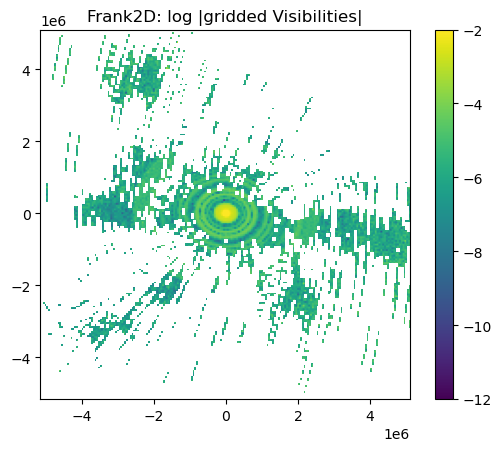

In [10]:
plt.figure()
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |gridded Visibilities|')
plt.colorbar()

In [11]:

u_gridded_2d = np.fft.fftshift(u_gridded.reshape(N, N))
v_gridded_2d = np.fft.fftshift(v_gridded.reshape(N, N))
vis_gridded_2d = np.fft.fftshift(vis_gridded.reshape(N, N))


vis_conjugated = np.copy(vis_gridded_2d)


threshold = 10**(-12)

# Trabajamos en los cuadrantes 1 y 2
for i in range(N // 2):
    for j in range(N // 2, N):  # Primer cuadrante
        u = u_gridded_2d[i, j]
        v = v_gridded_2d[i, j]
        
        # Encontrar las posiciones de (-u, -v) en la malla
        idx_neg = np.where((u_gridded_2d == -u) & (v_gridded_2d == -v))
        

        if idx_neg[0].size > 0 and idx_neg[1].size > 0:
            neg_i = idx_neg[0][0]
            neg_j = idx_neg[1][0]
            
            if np.abs(vis_conjugated[neg_i, neg_j]) < threshold:
                vis_conjugated[neg_i, neg_j] = np.conj(vis_gridded_2d[i, j])

for i in range(N // 2):
    for j in range(N // 2):  # Segundo cuadrante
        u = u_gridded_2d[i, j]
        v = v_gridded_2d[i, j]
        
        idx_neg = np.where((u_gridded_2d == -u) & (v_gridded_2d == -v))
        
        if idx_neg[0].size > 0 and idx_neg[1].size > 0:
            neg_i = idx_neg[0][0]
            neg_j = idx_neg[1][0]
            
            # Solo aplicar la propiedad conjugada si el valor existente en (-u, -v) es menor al umbral
            if np.abs(vis_conjugated[neg_i, neg_j]) < threshold:
                vis_conjugated[neg_i, neg_j] = np.conj(vis_gridded_2d[i, j])

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_1765/2213043703.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_conjugated.real)), extent=extent, origin='lower', vmin=-12, vmax=-2)


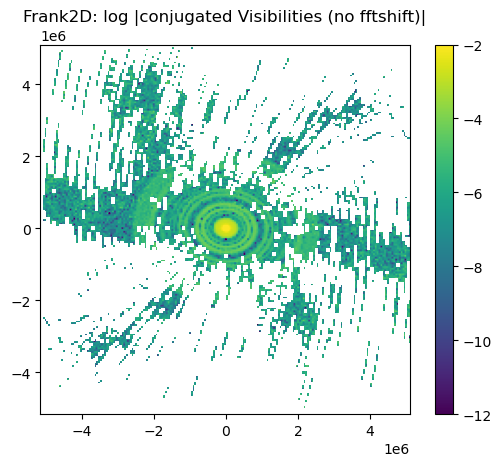

In [12]:
# Graficar el resultado después de imponer la propiedad
plt.figure()
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(vis_conjugated.real)), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |conjugated Visibilities (no fftshift)|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_1765/2229632895.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_conjugated.real))), extent=extent, origin='lower', vmin=-12, vmax=-2)


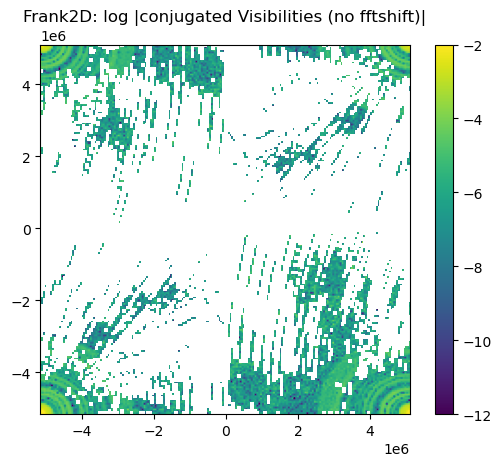

In [13]:
plt.figure()
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_conjugated.real))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |conjugated Visibilities (no fftshift)|')
plt.colorbar()

In [14]:
vis_gridded_filled = np.fft.fftshift(vis_conjugated).flatten()

In [15]:
start_time = time.time()

#####
frank2d = Frank2D(N, Rout)
frank2d.set_guess(vis_gridded_filled)
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, kernel_params=[m, c, l], method = 'cg', rtol = '1e-15')

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting guess...
Gridding...
  --> time = 0.01  min |  0.39 seconds
Setting fit with cg ...
Setting kernel...SquareExponential, with params: [-0.33, -0.1, 10000.0]
Fitting...
  *  Constructing linear operators...
     --> time = 1.22  min |  73.13 seconds
  *  Solving linear system...
         * rtol: 1e-15
         * final tolerance: 9.281044394609595e-08
maxiter:  20
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
  --> CGM converged in  5  iterations
     --> time = 3.32  min |  199.28 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                    !!!!!!!!!!!!!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds
--------------------------------------
time = 4.90  min |  293.94 seconds


In [16]:
r, I = get_radial_profile(frank2d)

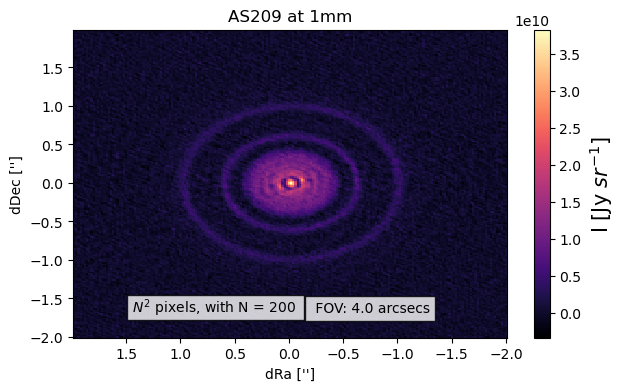

In [17]:
Plot(frank2d).get_image('AS209 at 1mm')

In [67]:
start_time = time.time()

#####

frank2d_2 = Frank2D(N, Rout)
frank2d_2.fit(u_deproj, v_deproj, vis_deproj, Weights, kernel_params=[m, c, l], method = 'cg', rtol = '1e-15')

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Gridding...
  --> time = 0.01  min |  0.38 seconds
Setting fit with cg ...
Setting kernel...SquareExponential, with params: [-0.33, -0.1, 10000.0]
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
     --> time = 0.10  min |  5.93 seconds
  *  Solving linear system...
         * rtol: 1e-15
         * final tolerance: 9.281022820317443e-08
maxiter:  20
iteration:  0
iteration:  1
iteration:  2
  --> CGM converged in  2  iterations
     --> time = 0.13  min |  7.90 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                    !!!!!!!!!!!!!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds
--------------------------------------
time = 0.27  min |  16.04 seconds


In [71]:
r_2, I_2 = get_radial_profile(frank2d_2)

In [20]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

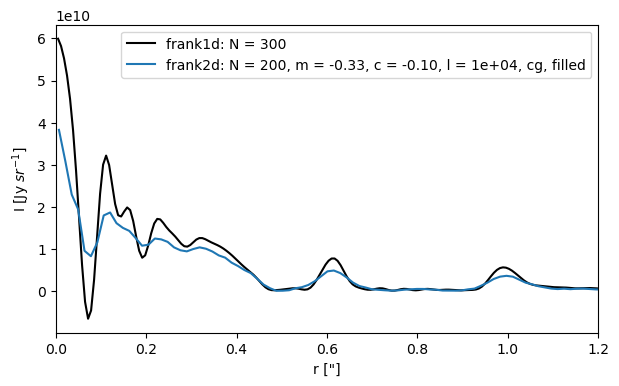

In [21]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N}, m = {m:.2f}, c = {c:.2f}, l = {l:.0e}, cg, filled')
#plt.plot(r_2, I_2, label = f'frank2d: N = {N}, m = {m:.2f}, c = {c:.2f}, l = {l:.0e}, cg')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)           
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

40000
40000


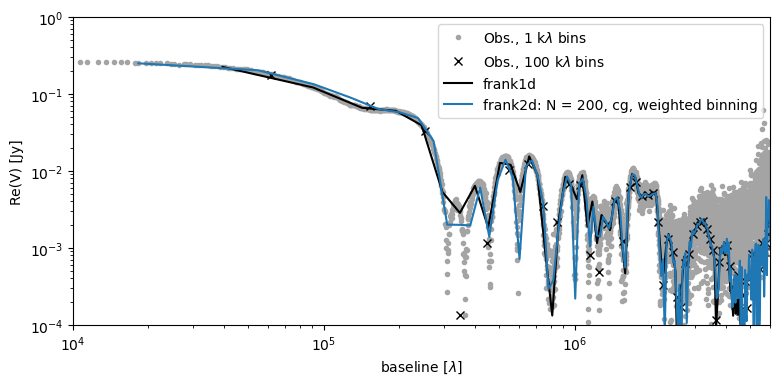

In [72]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(9,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))

u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']
#weights_gridded = frank2d._gridded_data['weights']
#baselines_gridded = np.hypot(u_gridded, v_gridded)
#binned_vis_gridded = UVDataBinner(baselines_gridded, vis_gridded, np.ones_like(weights_gridded), bin_widths[1])
#plt.plot(binned_vis_gridded.uv, np.abs(binned_vis_gridded.V),  marker='.', ls='None')

#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_weighted, Vis_mean = get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_weighted.real), label = f'frank2d: N = {N}, {method1}, weighted binning')#, cg')#, m = {m:.2f}, c = {c:.2f}')
#plt.plot(q, np.abs(Vis_mean.real), label = f'frank2d: N = {N}, {method1}, mean binning')#, cg')#, m = {m:.2f}, c = {c:.2f}')

#q_2, Vis_2 = get_vis_profile(frank2d_2)
#plt.plot(q_2, np.abs(Vis_2.real), label = f'frank2d: N = {N}, {method2}')#, m = {m:.2f}, c = {c:.2f}')


plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend()
plt.show()

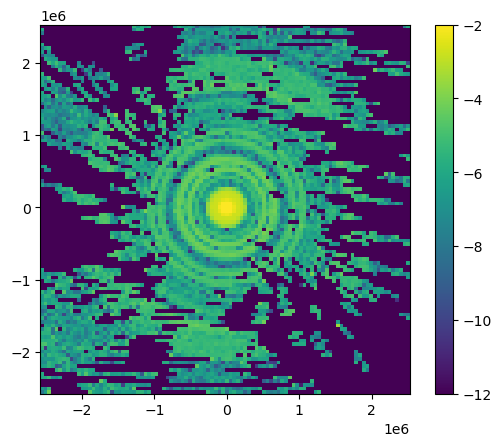

In [63]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
#plt.title("Frank2D N = 200, solution for log |Visibilities| ")
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_98822/2583945580.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


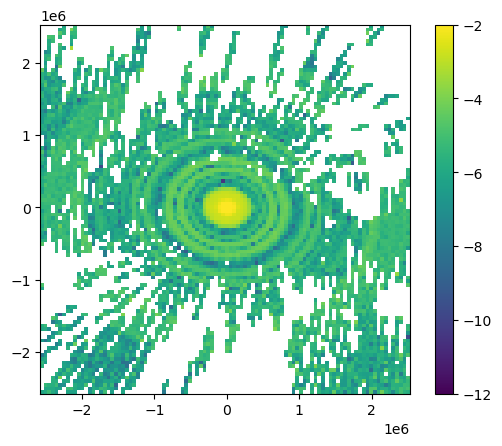

In [64]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.colorbar()

### Wendland matrix approach

In [259]:
N = 50

In [260]:
frank2d = Frank2D(N, Rout)

In [289]:
u = frank2d._FT._Un
v = frank2d._FT._Vn
u1, u2 = np.meshgrid(u, u)
v1, v2 = np.meshgrid(v, v)
q = np.sqrt((u1-u2)**2 + (v1-v2)**2)
q_f = q.flatten()

### SE Kernel

In [262]:
l = 1e4
m = -0.33
c = -0.1
N = 50

In [263]:
def SE_kernel(u = frank2d._FT._Un, v= frank2d._FT._Vn): 
    u1, u2 = np.meshgrid(u, u)
    v1, v2 = np.meshgrid(v, v)
    q1 = np.hypot(u1, v1)
    q2 = np.hypot(u2, v2)
    min_freq = v[1]
    print(min_freq)

    def power_spectrum(q, m, c):
        q[q == 0] = min_freq
        return np.exp(m*np.log(q) + c)

    p1 = power_spectrum(q1, m, c)
    p2 = power_spectrum(q2, m, c)
    
    factor = np.sqrt(p1 * p2)
    
    SE_Kernel = np.exp(-0.5*((u1-u2)**2 + (v1-v2)**2)/ l**2) * factor 

    return SE_Kernel, factor

In [264]:
matrixSE = SE_kernel()[0]

51566.20156177409


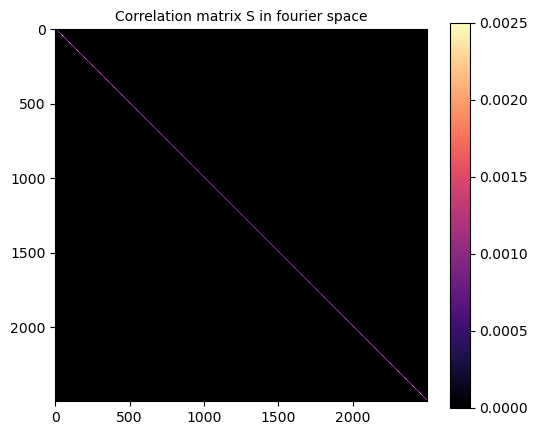

In [314]:
plt.figure(figsize=(6,10))
plt.imshow(matrixSE, cmap =  'magma', vmin = 0, vmax = 0.0025)
plt.colorbar(shrink=0.5)
plt.title(r'Correlation matrix S in fourier space', size = 10)
plt.show()

In [298]:
if np.all(np.linalg.eigvals(matrixSE) > 0): print("definite positive")

definite positive


In [299]:
np.max(matrixSE)

0.025205194610750464

In [300]:
matrixSE[40][40]

0.011789355262430705

In [301]:
np.where( matrixSE == np.max(matrixSE))

(array([   0,    1,   49,   50, 2450]), array([   0,    1,   49,   50, 2450]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


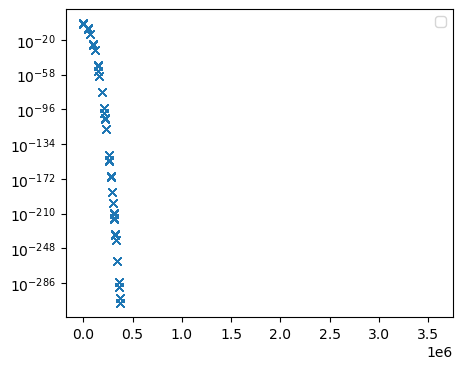

In [302]:
plt.figure(figsize=(5,4))
plt.plot((q.flatten()), matrixSE.flatten(), ls = 'None', marker = 'x')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(-1e1, 1e1)
plt.legend()
plt.show()

### Wendland

$ ϕ_{ℓ,k}(r)=(1−r)_{+}^{ℓ} P_{k}(r)$. For another hand $r = \frac{|| x_{i} - x_{j}||}{h}$

* such function has value between [0, h] and 0 if not.
* with $ℓ=⌊d/2⌋+k+1$, where $d$ is the dimension of our problem.

**OUR PROBLEM** 
* $d$ = 2 (we are correlating baselines)
* k increase the degree of the polynomia, so increase this value is a better aprox. Smoothness
*  h is like $l$ in the SE Kernel, because definess the smoothnes.

In [270]:
from numpy.polynomial import Polynomial

def P_k(r, k):
    if k == 0:
        return np.ones_like(r)  # P_0(r) = 1
    elif k == 1:
        return Polynomial([1, 4])(r)  # P_1(r) = 4r + 1
    elif k == 3:
        return Polynomial([3, 18, 35])(r)  # P_2(r) = 35r^2 + 18r + 3
    else:
        raise ValueError("k must be 0, 1, or 2.")

In [271]:
def Wendland_kernel(input, amp, h, threshold, l = 3, k = 1):
    u1, u2 = np.meshgrid(input[0], input[0])
    v1, v2 = np.meshgrid(input[1], input[1])
    r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
    r_normalized = r/h

    factor = (1 - r_normalized)**l
    factor[r_normalized > threshold] = 0

    return amp * factor * P_k(r_normalized, k)

In [303]:
h = 5e5
l = 4
k = 1
amplitude = 0.025
threshold = 1

In [304]:
print(r'which type?:  ϕ_{', l-k,',',  k, '}')

which type?:  ϕ_{ 3 , 1 }


In [305]:
#amplitude = SE_kernel()[1]

In [306]:
matrixW = Wendland_kernel([u, v], amplitude, h, threshold, l = l, k = k)

In [307]:
matrixW_2 = Wendland_kernel([u, v], amplitude, 1e1*h, threshold, l = l, k = k)

In [308]:
matrixW_3 = Wendland_kernel([u, v], amplitude, 3e4, threshold, l = l, k = k)

In [309]:
if np.all(np.linalg.eigvals(matrixW) > 0): print("definite positive")

definite positive


In [310]:
q_array = q.flatten()

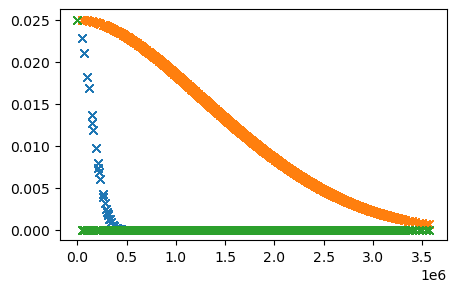

In [311]:
plt.figure(figsize=(5,3))
plt.plot(q_array, matrixW.flatten(), ls = 'None', marker = 'x')
plt.plot(q_array, matrixW_2.flatten(), ls = 'None', marker = 'x')
plt.plot(q_array, matrixW_3.flatten(), ls = 'None', marker = 'x')
#plt.axvline(threshold, c = 'red', label = 'threshold')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

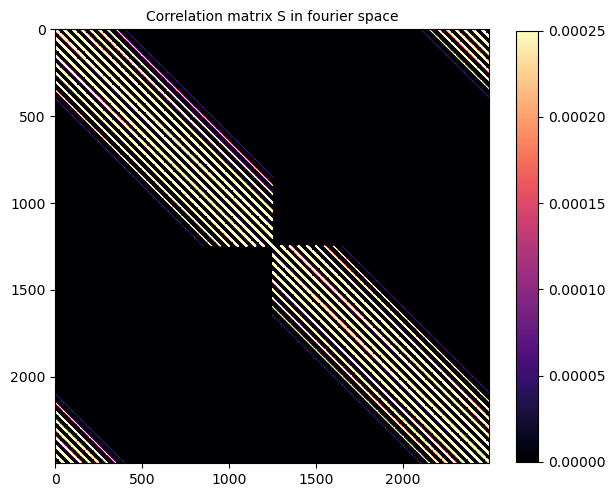

In [313]:
plt.figure(figsize=(7,7))
plt.imshow(matrixW, cmap =  'magma', vmin = 0, vmax = 0.00025)
plt.colorbar(shrink=0.8)
plt.title(r'Correlation matrix S in fourier space', size = 10)
plt.show()

In [286]:
matrixW[40][40]

0.025

### Comparison

In [315]:
matrixSE_f = matrixSE.flatten()
matrixW_f = matrixW.flatten()

In [316]:
matrixSE.size
matrixSE.max()

0.025205194610750464

In [317]:
q[q!=0].min()

51566.201561773894

In [318]:
len(np.where((matrixSE_f > 1e-3) == True)[0])/matrixSE.size *100

0.04

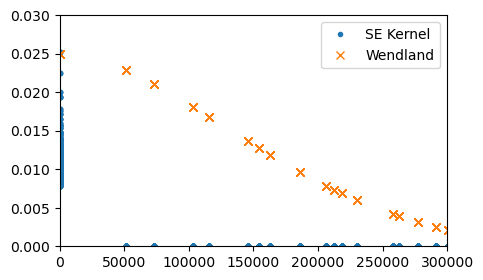

In [319]:
plt.figure(figsize=(5,3))
plt.plot(q.flatten(), matrixSE_f, ls = 'None', marker = '.', label = 'SE Kernel')
plt.plot(q.flatten(), matrixW_f, ls = 'None', marker = 'x', label = 'Wendland' )
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(0, 0.030)
plt.xlim(-20, 3e5)

plt.legend()
plt.show()

### Curve fit

In [322]:
def Wendland_kernel_fit(input, amp, h, l = 3, k = 1):
    u1, u2 = np.meshgrid(input[0], input[0])
    v1, v2 = np.meshgrid(input[1], input[1])
    r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
    r_normalized = r/h

    factor = (1 - r_normalized)**(l)
    factor[r_normalized > 1] = 0

    return (amp * factor * P_k(r_normalized, k)).flatten()

In [325]:
from scipy.optimize import curve_fit

se_kernel_values = matrixSE.flatten()

initial_guess = [0.025, 5e5] 
u, v = frank2d._FT._Un, frank2d._FT._Vn
params_opt, params_cov = curve_fit(Wendland_kernel_fit, [u,v] , se_kernel_values, p0=initial_guess)

amp_opt, h_opt = params_opt
print(f"Optimal parameters: amp = {amp_opt}, h = {h_opt}")

Optimal parameters: amp = 0.009990369249680536, h = 49473.54725195536


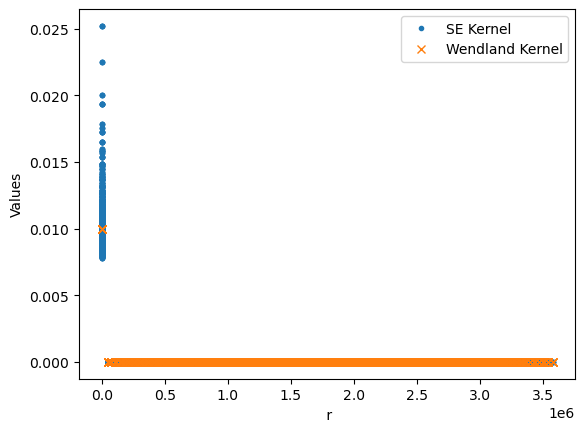

In [327]:
wendland_fitted = Wendland_kernel_fit([u,v], amp_opt, h_opt)

plt.plot(q.flatten() , se_kernel_values, label='SE Kernel', ls = 'None', marker = '.',)
plt.plot(q.flatten() , wendland_fitted, label='Wendland Kernel', ls = 'None', marker = 'x',)
plt.xlabel(' r')
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Values')
plt.legend()
plt.show()

### Trying Wendland kernel

In [328]:
N = 100

In [329]:
frank2d = Frank2D(N, Rout)
frank2d.set_kernel('Wendland', [3, 1, amp_opt, h_opt])
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, method = 'bicgstab', rtol = '1e-25')

Setting kernel...Wendland, with params: [3, 1, 0.009990369249680536, 49473.54725195536]
Gridding...
  --> time = 0.01  min |  0.66 seconds
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
     --> time = 0.02  min |  1.00 seconds
  *  Solving linear system...
         * rtol: 1e-25
         * final tolerance: 8.387789278664164e-38
         * maxiter:  100000
             .. iteration:  1
     --> time = 0.04  min |  2.40 seconds
solution:  [2.27595720e-13+5.52705939e-17j 1.84019466e-13-3.23539481e-16j
 1.19251831e-13-6.56592836e-16j ... 8.31834601e-14+1.18828558e-15j
 1.39069312e-13+1.08723794e-15j 1.89404048e-13+7.84908163e-16j]
  --> CGM converged?   True
  --> Fit correctly?   True
                                    !!!!!!!!!!!!!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds


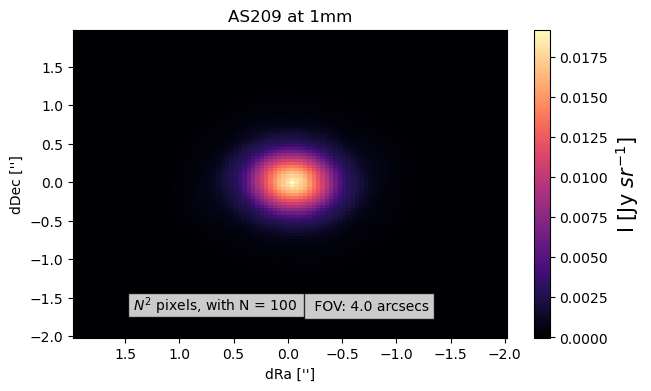

In [331]:
Plot(frank2d).get_image('AS209 at 1mm')

In [332]:
u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_90804/3527557431.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.real.reshape(N, N)))), extent=extent, origin='lower')#, vmin=-12, vmax=-2)


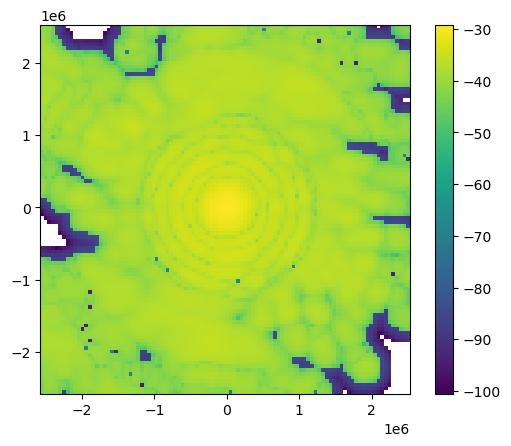

In [333]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.real.reshape(N, N)))), extent=extent, origin='lower')#, vmin=-12, vmax=-2)
#plt.title("Frank2D N = 200, solution for log |Visibilities| ")
plt.colorbar()